# Classifying Wikipedia Comments with BERT

This Notebook will show you how to fine-tune BERT for *document* classification tasks using the Wikipedia Personal Attacks dataset as an example. As a bonus, in part 3, we'll also look briefly at how we can apply BERT to search for "semantically similar" comments in the dataset.

In [1]:
import os
import time
import torch
import random
import urllib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(f"We have {torch.cuda.device_count()} GPUs available")
  print(f"Its name is {torch.cuda.get_device_name(0)}")
else:
  device = torch.device('cpu')

We have 1 GPUs available
Its name is Tesla P100-PCIE-16GB


Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT. 

In [3]:
!pip install transformers
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW

     |████████████████████████████████| 2.1MB 5.8MB/s 
     |████████████████████████████████| 3.3MB 52.8MB/s 
     |████████████████████████████████| 870kB 65.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=3203d266dbac463b6fbd4cd33aa2dd8a631d1ac26d18da9e84ee9b58127b4512
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Download

In [4]:
os.makedirs('data', exist_ok=True)
files = [
    ('./data/attack_annotated_comments.tsv',  'https://ndownloader.figshare.com/files/7554634'),
    ('./data/attack_annotations.tsv',         'https://ndownloader.figshare.com/files/7554637')   
]    
for (filename, url) in files:
  if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

Let's investigate the dataset.

In [5]:
comments = pd.read_csv('./data/attack_annotated_comments.tsv', sep='\t', index_col=0)
annotations = pd.read_csv('./data/attack_annotations.tsv', sep='\t')
comments.head()

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train


In [6]:
comments[['comment', 'split']].groupby('split').count()

,comment
split,
dev,23160
test,23178
train,69526


In [7]:
annotations.head()

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0


We will label text as attack if majority of the annotators did so. Each comment has unique `rev_id` and multiple rows with the same value of `rev_id` correspond to different decisions of annotators.

In [8]:
labels = annotations.groupby('rev_id')['attack'].mean() > .5
comments['attack'] = labels
comments.head()

,comment,year,logged_in,ns,sample,split,attack
rev_id,,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train,False
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train,False
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train,False
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,False
93890,This page will need disambiguation.,2002,True,article,random,train,False


In [9]:
#removing unnecessary tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace('NEWLINE_TOKEN', ' '))
comments['comment'] = comments['comment'].apply(lambda x: x.replace('TAB_TOKEN', ' '))
#splitting dataset
train_comments = comments.query('split=="train"')
test_comments = comments.query('split=="test"')
print(f"train_comments.shape: {train_comments.shape}, test_comments.shape: {test_comments.shape}")

train_comments.shape: (69526, 7), test_comments.shape: (23178, 7)


In [10]:
num_of_comments = comments.shape[0]
num_of_attacks = comments.query('attack').shape[0]
attacks_to_all_ratio = num_of_attacks / num_of_comments
print(f"Percent of attacks in our dataset is {attacks_to_all_ratio*100:.2f}%")

Percent of attacks in our dataset is 11.73%


We're working with highly skewed targets in our dataset. We should be careful interpreting accuracy.

In [11]:
print(f"Always predicting 'not attack' will produce {(1 - attacks_to_all_ratio)*100:.2f}% accuracy")

Always predicting 'not attack' will produce 88.27% accuracy


# Time to load BERT Tokenizer.

In [12]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

We're going to convert texts into tokens and append special [CLS] and [SEP] tokens as BERT expects. Also along with that, we want to calculate the length of each sentence after tokenization to see the distribution of lengths. That will help us to make a decision on truncation value as BERT can take maximum of 512 tokens at the input.

In [13]:
input_ids = []
lengths = []
for sentence in train_comments.comment:
  if (len(input_ids) + 1) % 20000 == 0:
    print(f"Tokenized {len(input_ids)+1} comments.")
  tokenized_comment = tokenizer.encode(sentence, add_special_tokens=True)
  input_ids.append(tokenized_comment)
  lengths.append(len(tokenized_comment))
print('DONE')

Tokenized 20000 comments.
Tokenized 40000 comments.
Tokenized 60000 comments.
DONE


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


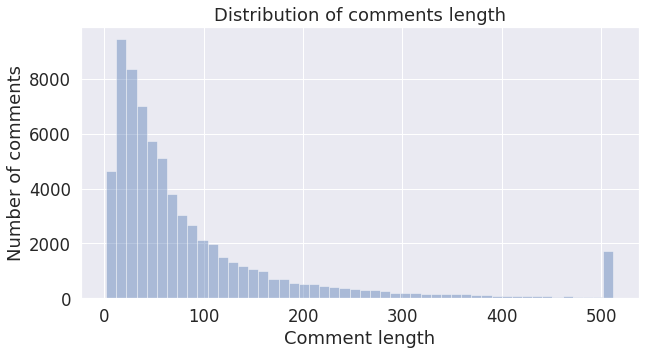

In [14]:
# plotting the distribution of comment lengths
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10, 5)
lengths = [min(len, 512) for len in lengths]
sns.distplot(lengths, kde=False)
plt.title('Distribution of comments length')
plt.xlabel('Comment length')
plt.ylabel('Number of comments')
plt.show()

It's interesting to see how many comments are over 512 tokens and the fraction of them that actually contain attack.

In [15]:
labels

rev_id
37675        False
44816        False
49851        False
89320        False
93890        False
             ...  
699848324    False
699851288    False
699857133    False
699891012    False
699897151    False
Name: attack, Length: 115864, dtype: bool

In [16]:
num_truncated = lengths.count(512)
num_sentences = len(lengths)
print(f"Percentage of truncated sentences: {num_truncated/num_sentences*100:.2f}%")

labels = train_comments.attack.to_numpy().astype(int)
num_pos = 0
num_neg = 0
for i, l in enumerate(lengths):
  if l == 512:
    if labels[i] == 0:
      num_neg += 1
    else:
      num_pos += 1
print(f"Percentage of truncated sentences that actually contained attack: {num_pos/num_truncated*100:.2f}%")

Percentage of truncated sentences: 2.40%
Percentage of truncated sentences that actually contained attack: 12.11%


It's safe to assume that 512 tokens is enough: we won't lose much texts. Actually we'll go even further and use maximum length of 128 as and "elbow" point on the plotted distribution.

In [17]:
MAX_LEN = 128
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', padding='post', truncating='post', value=0)
print(f"input_ids.shape: {input_ids.shape}")

input_ids.shape: (69526, 128)


The attention mask simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [18]:
attention_masks = []
for sent in input_ids:
  att_msk = [int(token_id > 0) for token_id in sent]
  attention_masks.append(att_msk)
attention_masks = np.array(attention_masks)
print(f"attention_masks.shape: {attention_masks.shape}")

attention_masks.shape: (69526, 128)


Next step would be splitting our dataset into train/validation, converting them into data type expected by PyTorch and creating DataLoader that will feed batches of dat into the GPU's memory.

In [19]:
train_input_ids, validation_input_ids, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2021, test_size=.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2021, test_size=.1)

train_input_ids = torch.tensor(train_input_ids)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_input_ids = torch.tensor(validation_input_ids)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

batch_sz = 64
train_data = TensorDataset(train_input_ids, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_sz)

validation_data = TensorDataset(validation_input_ids, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_sz)

# BERT Fine-tuning

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

In [20]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Let's define some gelper functions

In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.mean(pred_flat == labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Time to actually train our model

In [23]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print(f'======== Epoch {epoch_i} / {epochs} ========')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.    Elapsed: {elapsed}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training epcoh took: {format_time(time.time() - t0)}")
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_accuracy = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print(f"  Accuracy: {eval_accuracy/nb_eval_steps:.2f}")
    print(f"  Validation took: {format_time(time.time() - t0)}")

print("")
print("Training complete!")



======== Epoch 0 / 4 ========
Training...
  Batch   100  of    978.    Elapsed: 0:01:12.
  Batch   200  of    978.    Elapsed: 0:02:24.
  Batch   300  of    978.    Elapsed: 0:03:37.
  Batch   400  of    978.    Elapsed: 0:04:49.
  Batch   500  of    978.    Elapsed: 0:06:01.
  Batch   600  of    978.    Elapsed: 0:07:13.
  Batch   700  of    978.    Elapsed: 0:08:25.
  Batch   800  of    978.    Elapsed: 0:09:38.
  Batch   900  of    978.    Elapsed: 0:10:50.

  Average training loss: 0.22
  Training epcoh took: 0:11:46

Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:26

======== Epoch 1 / 4 ========
Training...
  Batch   100  of    978.    Elapsed: 0:01:12.
  Batch   200  of    978.    Elapsed: 0:02:24.
  Batch   300  of    978.    Elapsed: 0:03:37.
  Batch   400  of    978.    Elapsed: 0:04:49.
  Batch   500  of    978.    Elapsed: 0:06:01.
  Batch   600  of    978.    Elapsed: 0:07:13.
  Batch   700  of    978.    Elapsed: 0:08:26.
  Batch   800  of    978.    Elap

# Evaluation on the test set

At first we will do all the needed prerocessing for the test set. Then we will do predictions.

In [24]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sen in test_comments.comment:
    
    # Report progress.
    if ((len(input_ids) % 20000) == 0):
        print(f'  Read {len(input_ids)} comments.')
    
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sen,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,          # Truncate all sentences.                        
                   )
    
    # Add the encoded sentence to the list.
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print(f'{len(test_input_ids):>10,} test comments')

# Also retrieve the labels as a list.

# Get the labels from the DataFrame, and convert from booleans to ints.
test_labels = test_comments.attack.to_numpy().astype(int)

print(f'{np.sum(test_labels):>10,} positive (contains attack)')
print(f'{len(test_labels) - np.sum(test_labels):>10,} negative (not an attack)')

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                               dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


DONE.

    23,178 test comments
     2,756 positive (contains attack)
    20,422 negative (not an attack)


In [25]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step, batch) in enumerate(test_dataloader):
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Progress update every 100 batches.
    if step % 100 == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Report progress.
        print(f'  Batch {step:>5,}  of  {len(test_dataloader):>5,}.    Elapsed: {elapsed}.')


    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask,
                       return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 23,178 test sentences...
  Batch   100  of    725.    Elapsed: 0:00:12.
  Batch   200  of    725.    Elapsed: 0:00:24.
  Batch   300  of    725.    Elapsed: 0:00:37.
  Batch   400  of    725.    Elapsed: 0:00:49.
  Batch   500  of    725.    Elapsed: 0:01:01.
  Batch   600  of    725.    Elapsed: 0:01:13.
  Batch   700  of    725.    Elapsed: 0:01:26.
    DONE.


The accuracy metric chosen by the authors for this dataset is the "ROC AUC" (Receiver Operating Characteristic, Area Under the Curve) rather than straight accuracy (number right / total examples).

*ROC AUC*

To illustrate the purpose of this metric, let's say that you were going to deploy this comment classifier on your website to automatically flag bad comments. In order to do that, you would have to make a decision about how confident you needed the classifier to be before flagging a comment as a personal attack.
* If it was critical that no bad comments be missed, then you might choose to set a fairly low threshold, and then have a human review what the classifier flags. This would help ensure that bad comments would be caught, but at the cost of getting more false positives that the moderator would have to deal with.
* If it wasn't critical to catch them all, and you wanted as few as possible to manually review, then you might you set a higher threshold so that you don't have as many flagged comments to review (at the risk of missing some attacks). 

The ROC AUC takes into account the fact that you can adjust the threshold to trade off false positives and false negatives, and yields a score which tries to capture overall accuracy independent of where you choose to put that threshold.

In [26]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Use the model output for label 1 as our predictions.
p1 = predictions[:,1]

# Calculate the ROC AUC.
auc = roc_auc_score(true_labels, p1)

print(f'Test ROC AUC: {auc:.3f}')

Test ROC AUC: 0.964


# Saving the model

In [27]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save/'

# Create output directory if needed
os.makedirs(output_dir, exist_ok=True)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

# Backing Up to Google Drive

In [28]:
drive.mount('/content/drive')

gdrive_path = "./drive/MyDrive/"

os.makedirs(gdrive_path, exist_ok=True)

# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/"

Mounted at /content/drive


# Part III - Semantic Similarity

In Part III, we'll walk through an example of using BERT to measure the "semantic similarity" of two pieces of text. "Semantic similarity" refers to how close in meaning the pieces of text are.

As a demonstration of this capability, we'll implement code to compare an arbitrary piece of input text (it could be from the dataset or one we supply ourselves) with all of the comments in the dataset and return the comments that are most similar in meaning to the input text.

In this section, we will use our fine-tuned BERT model to extract sentence embeddings for all of the training comments.

To create these embeddings, we'll simply run the comments through the model the same way we did for training, but we'll take the embedding corresponding to the `[CLS]` token from the final BERT Transformer layer. It's the blue rectangle at the top left of the following illustration:

[![Illustration of CLS token purpose](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)](https://drive.google.com/uc?export=view&id=1ck4mvGkznVJfW3hv6GUqcdGepVTOx7HE)

#  Modifying Our Model to Output Embeddings

Important: Before we can use our fine-tuned model for extracting embeddings, we first need to reload the model from disk with the `output_hidden_states` flag set to `True`.

In [29]:
# !cp -r "./drive/My Drive/model_save/" ./model_save/

# Load our fine-tuned model, and configure it to return the "hidden states", 
# from which we will be taking our text embeddings.
model = BertForSequenceClassification.from_pretrained(
    output_dir,
    output_hidden_states = True, # Whether the model returns all hidden-states.
) 

# Load the tokenizer.
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Here we'll define a function which can take an arbitrary piece of text and use our fine-tuned BERT model to compute a feature vector (aka "embedding") for the text.

In [30]:
def text_to_embedding(tokenizer, model, in_text):
    '''
    Uses the provided BERT `model` and `tokenizer` to generate a vector 
    representation of the input string, `in_text`.

    Returns the vector stored as a numpy ndarray.
    '''

    # ===========================
    #    STEP 1: Tokenization
    # ===========================

    MAX_LEN = 128

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Truncate the sentence to MAX_LEN if necessary.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end. (After truncating!)
    #   (4) Map tokens to their IDs.
    input_ids = tokenizer.encode(
                        in_text,                    # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.                        
                   )    

    # Pad our input tokens. Truncation was handled above by the `encode`
    # function, which also makes sure that the `[SEP]` token is placed at the
    # end *after* truncating.
    # Note: `pad_sequences` expects a list of lists, but we only have one
    # piece of text, so we surround `input_ids` with an extra set of brackets.
    results = pad_sequences([input_ids], maxlen=MAX_LEN, dtype="long", 
                              truncating="post", padding="post")
    
    # Remove the outer list.
    input_ids = results[0]

    # Create attention masks    
    attn_mask = [int(i>0) for i in input_ids]
    
    # Cast to tensors.
    input_ids = torch.tensor(input_ids)
    attn_mask = torch.tensor(attn_mask)

    # Add an extra dimension for the "batch" (even though there is only one 
    # input in this batch.)
    input_ids = input_ids.unsqueeze(0)
    attn_mask = attn_mask.unsqueeze(0)

    # ===========================
    #    STEP 2: BERT Model
    # ===========================

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Copy the inputs to the GPU
    # Note -- I got stuck here for a while because I didn't assign the result 
    # back to the variable! Geez!
    input_ids = input_ids.to(device)
    attn_mask = attn_mask.to(device)
    
    # Telling the model not to build the backwards graph will make this 
    # a little quicker.
    with torch.no_grad():        

        # Forward pass, return hidden states and predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        logits, encoded_layers = model(
                                    input_ids = input_ids, 
                                    token_type_ids = None, 
                                    attention_mask = attn_mask,
                                    return_dict=False)
        
    # Retrieve our sentence embedding--take the `[CLS]` embedding from the final
    # layer.
    layer_i = 12 # The last BERT layer before the classifier.
    batch_i = 0 # Only one input in the batch.
    token_i = 0 # The first token, corresponding to [CLS]
        
    # Grab the embedding.
    vec = encoded_layers[layer_i][batch_i][token_i]

    # Move to the CPU and convert to numpy ndarray.
    vec = vec.detach().cpu().numpy()

    return(vec)


In [31]:
# Get the text from one of the comments.
input_text = comments.iloc[10].comment

# Use the BERT model and tokenizer to generate an embedding for `input_text`.
vec = text_to_embedding(tokenizer, model, input_text)

print(f'\nDone. Embedding shape:{vec.shape}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



Done. Embedding shape:(768,)


In [32]:
# Track the time.
t0 = time.time()

# Store the set of embeddings.
embeddings = []

num_comments = len(comments)

print(f'Generating sentence embeddings for all {num_comments} comments...')

row_num = 0

# For each row of the dataframe...
for index, row in comments.iterrows():

    # Progress update every 2,000 comments.
    if row_num % 2000 == 0 and not row_num == 0:

        # Calculate elapsed time and format it.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        rows_per_sec = (time.time() - t0) / row_num
        remaining_sec = rows_per_sec * (num_comments - row_num)
        remaining = format_time(remaining_sec)

        # Report progress.
        print(f'  Comment {row_num:>7,}  of  {num_comments:>7,}.    Elapsed: {elapsed}. Remaining: {remaining}')

    # Vectorize this comment.
    vec = text_to_embedding(tokenizer, model, row.comment)

    # Store the embeddings.
    embeddings.append(vec) 

    row_num += 1

Generating sentence embeddings for all 115864 comments...
  Comment   2,000  of  115,864.    Elapsed: 0:00:22. Remaining: 0:21:06
  Comment   4,000  of  115,864.    Elapsed: 0:00:44. Remaining: 0:20:42
  Comment   6,000  of  115,864.    Elapsed: 0:01:06. Remaining: 0:20:08
  Comment   8,000  of  115,864.    Elapsed: 0:01:27. Remaining: 0:19:36
  Comment  10,000  of  115,864.    Elapsed: 0:01:48. Remaining: 0:19:04
  Comment  12,000  of  115,864.    Elapsed: 0:02:09. Remaining: 0:18:35
  Comment  14,000  of  115,864.    Elapsed: 0:02:30. Remaining: 0:18:09
  Comment  16,000  of  115,864.    Elapsed: 0:02:50. Remaining: 0:17:43
  Comment  18,000  of  115,864.    Elapsed: 0:03:12. Remaining: 0:17:22
  Comment  20,000  of  115,864.    Elapsed: 0:03:33. Remaining: 0:16:59
  Comment  22,000  of  115,864.    Elapsed: 0:03:54. Remaining: 0:16:38
  Comment  24,000  of  115,864.    Elapsed: 0:04:15. Remaining: 0:16:15
  Comment  26,000  of  115,864.    Elapsed: 0:04:36. Remaining: 0:15:53
  Comm

Since creating those embeddings was such a lengthy process, let's be sure to save the embeddings to disk in case we want to reload them another time.

In [33]:
# Convert the list of vectors into a 2D array.
vecs = np.stack(embeddings)

vecs.shape

(115864, 768)

In [34]:
# Use numpy to write out the matrix of embeddings.
print("Saving embeddings to: ./model_save/embeddings.npy")
np.save('./model_save/embeddings.npy', vecs)

# Copy the embeddings to a directory in your Google Drive.
#!cp -r ./model_save/embeddings.npy "./drive/My Drive/model_save/"

Saving embeddings to: ./model_save/embeddings.npy


# Semantic Similarity Search

Now that we have our comments all vectorized, we are ready to make them "searchable".

We do this using a technique called "k-Nearest Neighbor Search" or "k-NN". Simply put, we use a distance metric such as Euclidean distance, calculate that distance between our "query" vector and all of the vectors to be searched, then sort the distances to find the closest matches.

All of those distance calculations can make k-NN search computationally expensive and slow. There are a number of libraries out there for accelerating k-NN using carefully optimized code and / or approximation techniques.

I personally like the FAISS (Facebook AI Similarity Search) library, in part because it has a really excellent GPU implementation.

Using the GPU, we can perform "brute-force" k-NN search (meaning no approximation techniques which compromise on accuracy) on this dataset quickly.

In [35]:
!pip install faiss
!pip install faiss-gpu

     |████████████████████████████████| 4.7MB 5.7MB/s 
     |████████████████████████████████| 89.4MB 61kB/s 


In [36]:
import faiss

# Build a flat (CPU) index
cpu_index = faiss.IndexFlatL2(vecs.shape[1])

# Use 1 GPU.
n_gpu = 1

# Print the number of available GPUs. 
print(f'Number of available GPUs: {faiss.get_num_gpus()}    Using: {n_gpu}')

# If using multiple GPUs, enable sharding so that the dataset is divided across 
# the GPUs rather than replicated.
co = faiss.GpuMultipleClonerOptions()
co.shard = True

# Make it into a gpu index
gpu_index = faiss.index_cpu_to_all_gpus(cpu_index, co=co, ngpu=n_gpu)

# Add vecs to our GPU index
print('Adding dataset to index...')
t0 = time.time()    

gpu_index.add(vecs)

elapsed = time.time() - t0
print(f'Building index took {elapsed:.2f} seconds')

Number of available GPUs: 1    Using: 1
Adding dataset to index...
Building index took 0.08 seconds


Now let's try taking one of the comments from the dataset, and searching for the most semantically similar comments.

In [37]:
# Comment number 4 is short and sweet.
print('==== Input Comment =====')
print('Comment #4:')
print(comments.iloc[4].comment)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(vecs[4].reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print('"' + text + '"')
    print('')

==== Input Comment =====
Comment #4:
This page will need disambiguation. 

==== Top 5 Results ====
Comment #4:
L2 Distance: 0.00
"This page will need disambiguation. "

Comment #100,779:
L2 Distance: 0.57
" Description on image page is confusing about this.   "

Comment #8,975:
L2 Distance: 0.64
"For more details on this topic, see . "

Comment #101,805:
L2 Distance: 0.64
"I need help to improve this page."

Comment #105,064:
L2 Distance: 0.66
"still feel it belongs, feel free to explain.   "



Using our `text_to_embedding` function, we can also define new text to use as our query. Let's try writing a new sentence that's similar in meaning to comment #4, but uses different language. The word "disambiguate" means "remove uncertainty of meaning from", so I've written "The meaning of this page needs to be clarified."



In [38]:
query_text = "The meaning of this page needs to be clarified."

# Vectorize a new piece of text.
query_vec = text_to_embedding(tokenizer, model, query_text)

# Let's find the 5 most similar comments.
D, I = gpu_index.search(query_vec.reshape(1, 768), k=5) 

print('')
print('==== Top 5 Results ====')

# For each result...
for i in range(I.shape[1]):

    # Look up the comment row number for this result.
    result_i = I[0, i]

    # Look up the text for this comment.
    text = comments.iloc[result_i].comment

    print('Comment #{:,}:'.format(result_i))
    print('L2 Distance: %.2f' % D[0, i])
    print('"' + text + '"')
    print('')


==== Top 5 Results ====
Comment #84,400:
L2 Distance: 1.01
"  What does Mexico have to do with it?   "

Comment #74,594:
L2 Distance: 1.05
"Everything seems back to normal now, thanks.     "

Comment #54,132:
L2 Distance: 1.06
"  :Shouldn't it be Lone instead of lone?   "

Comment #89,523:
L2 Distance: 1.06
"accusation of sockpuppetery happened.}}"

Comment #42,819:
L2 Distance: 1.06
"Do not put your email or phone number on article pages.   "

